# Prep

In [ ]:
# import packages
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy import stats
import datetime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# load data
df = pd.read_csv("VOTER_Survey_Jan.csv", encoding = "ISO-8859-1")

# drop unnecessary columns
df.drop([col for col in df if col.startswith('starttime') or col.startswith('endtime')], axis=1, inplace=True)

# create separate data frames for survey years 2016 and 2019
df_2016 = df[[col for col in list(df) if col.endswith('2016')]]
df_2019 = df[[col for col in list(df) if (col.endswith('2019') or col == 'presvote16post_2016')]]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (653,654,892,893) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# PART 1: How do people feel about their past voting decision now?

In [ ]:
# PART 1: How do people feel about their past voting decision now?

# 2016 president vote column: presvote16post_2016
# create a list of column names for the relevant columns
vote_cols = ['presvote16post_2016', 'regretvote2016_2017', 'redovote2016_2017']
emo_2019_list = [col for col in list(df_2019) if col.startswith('emotion')] + vote_cols
# create dictionary of candidates and corresponding survey values
cand_dict = {'Clinton':1, 'Trump':2, 'Johnson':3, 'Stein':4, 'McMullin':5, 'Other':6, 'No vote':7}

# drop rows containing NaN, convert values to int, and drop nonsensical values of 9 from the redo column and 8 (skipped) from the emotion columns
emo_2019 = df[emo_2019_list].replace(9, np.nan).replace(8,np.nan).dropna().astype(np.int64)

# for regret, 1=Yes, 2=No
# for emotions, 1=do not feel at all, 7=feel very strongly
emo_2019.columns = ['angry','anxious','disgusted','sad','hopeful','enthusiastic','vote','regret', 'redo']

# transform regret column: 1=Yes, 0=No
emo_2019['regret'] = emo_2019['regret'].astype(str).str.replace('2','0').astype(int)

# create a list of the mean value of each question for each candidate
combined = []
for i in cand_dict:
    this_df = emo_2019[emo_2019['vote']==cand_dict[i]]
    combined.append([this_df[col].mean() for col in this_df.columns])

# combine the list of mean values, candidates names, and emotion columns into a data frame
emo_df = pd.DataFrame(data=combined, index=[i for i in cand_dict], columns=emo_2019.columns)

# drop columns for which .mean() is meaningless
emo_df.drop(['vote', 'redo'], axis=1, inplace=True)
print(emo_df.to_string())

             angry   anxious  disgusted       sad   hopeful  enthusiastic    regret
Clinton   5.649565  5.238662   6.027943  5.493816  3.403115      2.990838  0.037563
Trump     4.965741  4.290741   5.474537  4.688426  3.968981      3.506019  0.049537
Johnson   4.763889  4.263889   5.902778  4.944444  2.659722      2.333333  0.048611
Stein     5.846154  4.830769   6.230769  5.215385  2.415385      2.200000  0.138462
McMullin  4.666667  3.916667   5.666667  4.833333  3.416667      2.666667  0.166667
Other     5.207207  4.549550   5.927928  5.207207  2.639640      2.477477  0.054054
No vote   5.500000  4.125000   5.812500  5.312500  2.625000      2.062500  0.062500


In [ ]:
# create reverse dictionary of cand_dict by flipping key and value
cand_dict_r = {value : key for key, value in cand_dict.items()}
# format columns for visualization
emo_2019_points = emo_2019.drop(columns={'redo'})
emo_2019_points['vote'] = emo_2019_points['vote'].replace(cand_dict_r)
print(emo_2019_points.head().to_string(),'\n')
print(emo_2019_points.describe().to_string(),'\n')
#print(emo_2019_points['vote'].unique())

   angry  anxious  disgusted  sad  hopeful  enthusiastic     vote  regret
0      7        7          7    4        3             4  Clinton       0
2      7        7          7    7        7             7  Clinton       0
4      5        5          6    6        4             5    Trump       0
5      6        6          6    6        2             6  Clinton       0
6      6        5          6    7        4             1  Clinton       0 

             angry      anxious    disgusted          sad      hopeful  enthusiastic       regret
count  4691.000000  4691.000000  4691.000000  4691.000000  4691.000000   4691.000000  4691.000000
mean      5.296738     4.743125     5.768067     5.093157     3.606480      3.180772     0.045619
std       1.715037     1.796435     1.584012     1.796246     1.764224      1.743260     0.208680
min       1.000000     1.000000     1.000000     1.000000     1.000000      1.000000     0.000000
25%       4.000000     4.000000     5.000000     4.000000     2.

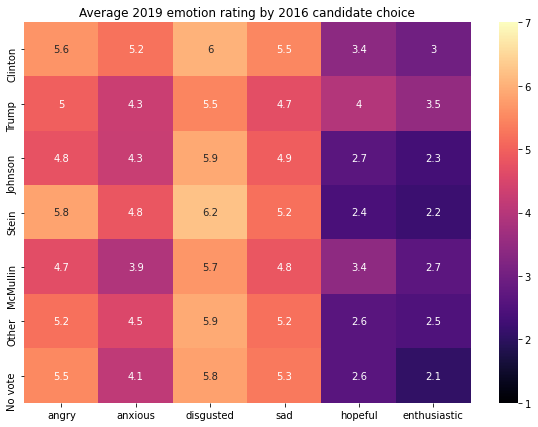

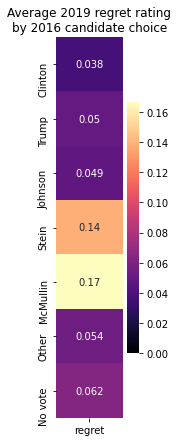

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(emo_df.drop(columns={'regret'}),vmin=1,vmax=7,annot=True,cmap='magma')
plt.title('Average 2019 emotion rating by 2016 candidate choice')
plt.show()
print()

plt.figure(figsize=(1.5,7))
sns.heatmap(pd.DataFrame(emo_df['regret']),vmin=0,annot=True,cmap='magma')
plt.title('Average 2019 regret rating\nby 2016 candidate choice')
plt.show()

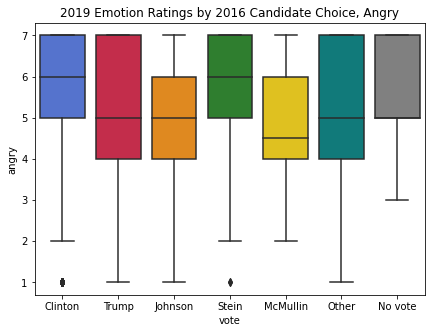

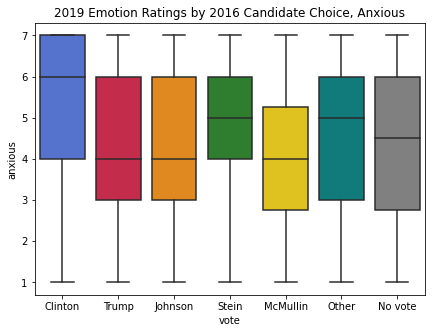

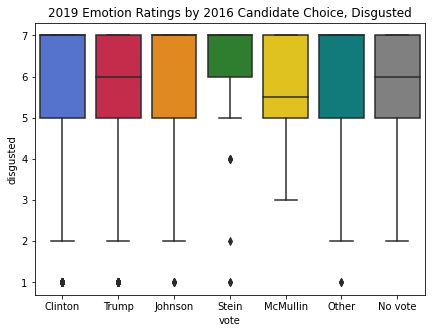

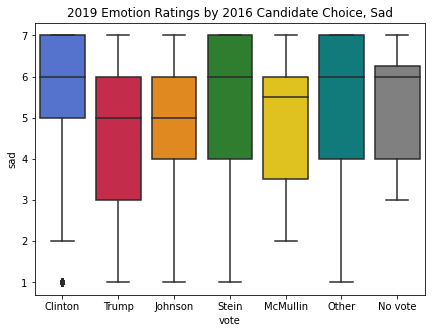

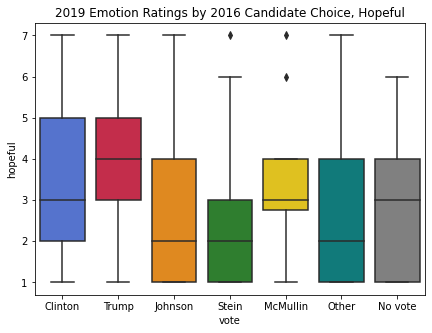

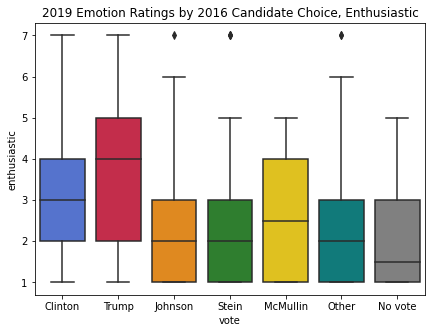

In [ ]:
custom_palette = ['royalblue','crimson','darkorange','forestgreen','gold','darkcyan','gray']
custom_order = ['Clinton','Trump','Johnson','Stein','McMullin','Other','No vote']

for emotion in emo_df.drop(columns={'regret'}).columns:
  plt.figure(figsize=(7,5))
  sns.boxplot(y=emo_2019_points[emotion],x=emo_2019_points['vote'],order=custom_order,palette=custom_palette,)
  plt.title('2019 Emotion Ratings by 2016 Candidate Choice, '+emotion[0].upper()+emotion[1:])
  plt.show()

# PART 2: What characteristics inform which candidate a person chooses?
###### Proportion for each response on topic questions that are asked in each survey

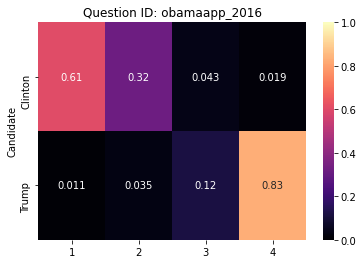

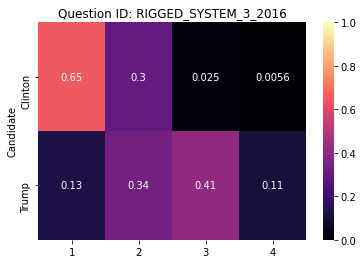

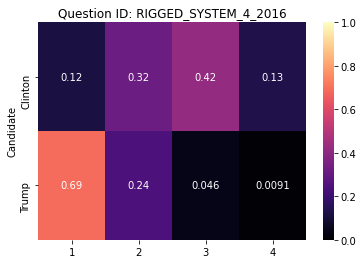

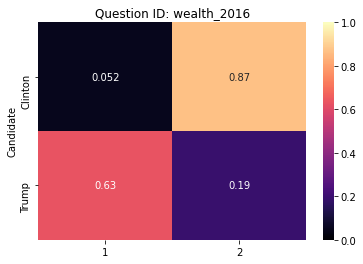

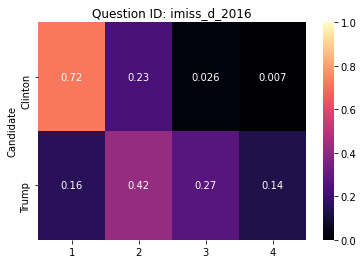

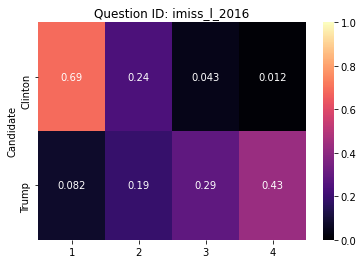

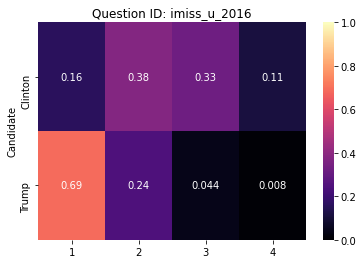

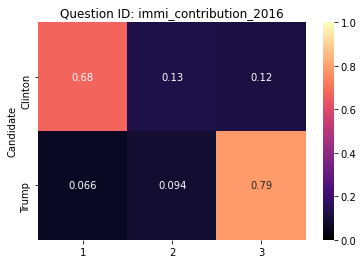

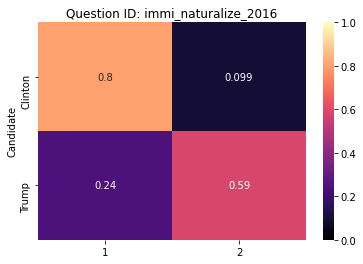

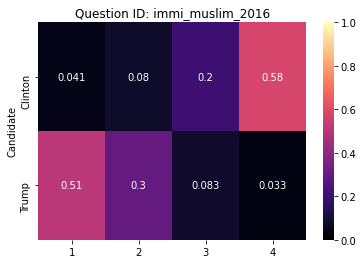

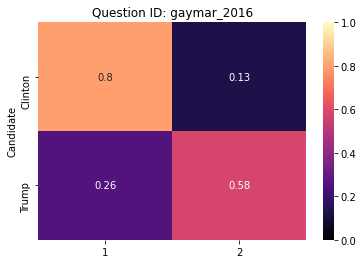

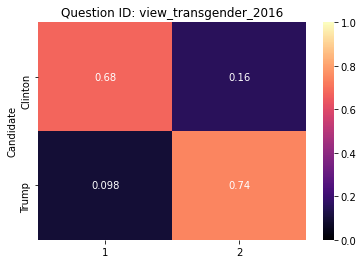

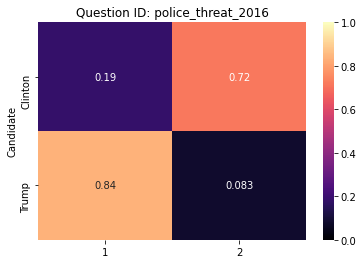

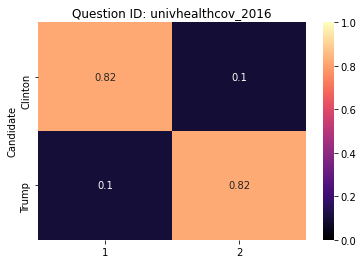

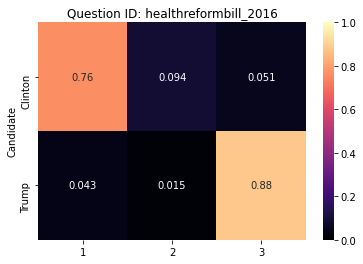

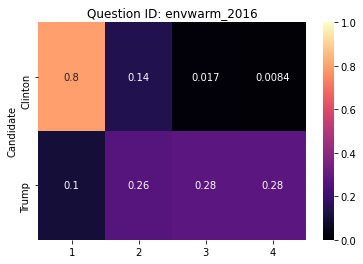

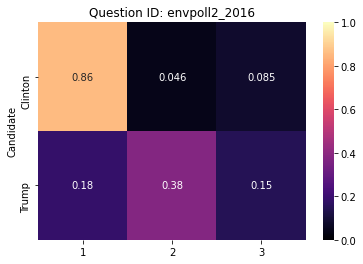

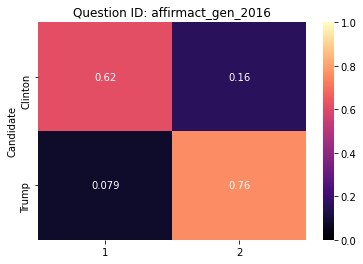

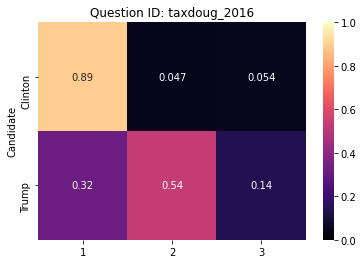

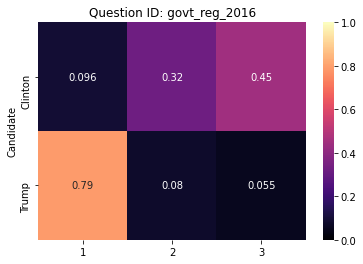

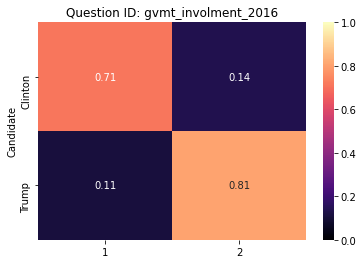

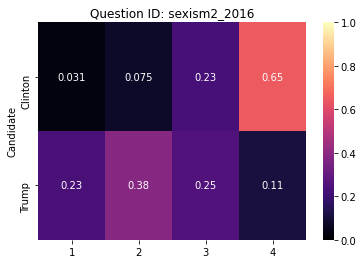

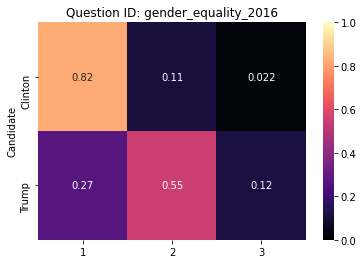

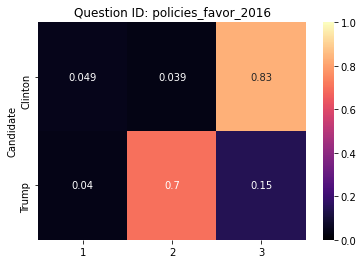

24


In [ ]:
def filter_df(df):
  # remove columns with open-ended responses
  to_remove = ['weight', 'inputstate', 'ft_', 'regzip', 'fav_', 'Sanders', 'Rubio', 'Cruz']
  for substring in to_remove:
      df = df[[col for col in df.columns if substring not in col]]
  # remove columns that have string type responses
  for col in df.columns:
      for val in df[col].unique():
          if type(val) == str:
              df.drop(col, axis=1, inplace=True)
              break
  return df

df_2016 = filter_df(df_2016)

# prepare indices of candidates and topics to create multi-index array
index1 = []
index2 = []
for candidate in cand_dict:
    for col in df_2016.columns:
        index1.append(candidate)
        index2.append(col)
topic_df = pd.DataFrame(index = [index1, index2])
topic_df.index.set_names(['Candidate', 'Topic'], inplace=True)

# calculate proportion of answers for each topic, for each candidate
for cand in cand_dict:
    this_df = df_2016[df_2016['presvote16post_2016']==cand_dict[cand]]
    for topic in this_df.columns:
        # normalize gives the proportion of total answers
        answer = this_df[topic].value_counts(normalize=True)
        # list of possible answers to this question
        possible_answers = answer.index.astype(np.int64)
        # list of the proportion of responses for each possible answer
        responses = list(answer)
        # insert the answer proportions at the index corresponding to this candidate and topic
        for idx, ans in enumerate(possible_answers):
            topic_df.loc[(cand, topic), ans] = responses[idx]

# now, topic_df is a multi-index data frame, where each column is a possible response
topic_df = topic_df.reindex(columns=sorted(list(topic_df)))
topics = list(df_2016)

# remove columns that are not topic-related questions
to_delete = ['presvote16post_2016', 'vote_for_against_2016', 'ccap2012_post_2016', 
             'vote_usual_2016', 'turnout16_2016', 'votereg2_2016', 'votereg_f_2016',
             'pp_primary16_2016','pid7_2016','pid3_2016']
for i in to_delete:
    topics.remove(i)

# create a data frame of the most divisive topics
divisive_df = pd.DataFrame()
divisive_topics = []
for topic in topics:
    # example of subsetting topic_df indices for each topic and keeping only Clinton and Trump
    this_topic_df = topic_df[topic_df.index.get_level_values('Topic').isin([topic]) & 
                             topic_df.index.get_level_values('Candidate').isin(['Clinton', 'Trump'])].dropna(axis=1)
    # create list of the absolute value of differences between Trump and Clinton answer proportions                          
    diffs = [abs(this_topic_df.iloc[0,i] - this_topic_df.iloc[1,i]) for i in range(len(list(this_topic_df)))]
    # if the difference of any column is above 0.5, the topic is considered divisive
    if any(diff > .5 for diff in diffs):
        divisive_topics.append([topic])
        # drop columns with value > 4, as these are responses that are either erroneous or indecisive
        this_topic_df.drop([col for col in list(this_topic_df) if col > 4], axis=1, inplace=True)
        this_topic_df = this_topic_df.reset_index()
        # prepare the data frame for visualization
        divisive_df = divisive_df.append(this_topic_df,ignore_index=True)
        # create heatmap
        sns.heatmap(this_topic_df.drop(columns={'Topic'}).set_index('Candidate'),vmin=0,vmax=1,annot=True,cmap='magma')
        plt.title('Question ID: '+this_topic_df['Topic'].max())
        plt.show()
        #print(this_topic_df.drop(columns={'Topic'}),'\n')
print(len(divisive_topics))
#print(divisive_df)

most divisive, non-candidate related topics:
*   wealth_2016 - distribution of wealth in the country
*   imiss_l_2016 - issue importance - climate change
*   immi_contribution_2016 - illegal immigrants make a contribution to the country or are a drain
*   immi_muslim_2016 - favor/not favor temporary ban on Muslims from entering country
*   view_transgender_2016 - public restroom usage of transgender people
*   police_threat_2016 - are killings of African American men isolated incidents or part of a broader pattern
*   univhealthcov_2016 - is it the fed gov's responsibility to ensure everyone has health care
*   healthreformbill_2016 - should healthcare bill be expanded, repealed, or kept the same
*   envwarm_2016 - do you think global warming is happening
*   envpoll2_2016 - do you think global warming has been caused by humans or natural causes
*   affirmact_gen_2016 - favor/not favor affirmative action programs for women and racial minorities
*   taxdoug_2016 - favor/not favor raising taxes on families with annual incomes over $200,000 
*   govt_reg_2016 - is there too much/little gov regulation of business
*   gvmt_involment_2016 - role of gov in economy
*   policies_favor_2016 - do Obama's policies favor whites over blacks, blacks over whites, or treat both groups equally

# PART 3: Can this data inform how people might behave in 2020?

In [ ]:
# drop columns that are directly related to party/candidate
df_lr_2016 = df_2016.drop(['turnout16_2016','vote_usual_2016','pp_primary16_2016', 'pp_demprim16_2016', 'wished_voted_2016', 'pp_repprim16_2016', 'free_trade_5_2016', 'obamaapp_2016', 'pid7_2016',
              'second_chance_2016', 'ideo5_2016', 'vote2016_cand2_2016', 'votereg2_2016'] + [col for col in list(df_2016) if col.startswith('PARTY')], axis=1)

# comment out to keep party ID column in data; uncomment to remove
df_lr_2016 = df_lr_2016.drop(['pid3_2016'],axis=1)

# condition y by selecting only Trump and Clinton voters, then convert 2 (voted for Trump) to 0 so that y is binary (0,1)
df_lr_2016 = df_lr_2016[df_lr_2016['presvote16post_2016'].isin([1,2])]
df_lr_2016['presvote16post_2016'] = df_lr_2016['presvote16post_2016'].replace(2,0)

def prep_lr_df(df):
  '''prep_lr_df performs preprocessing to prepare the data frame for model use'''
  # remove rows for which the 2016 presidential vote is missing
  df_lr = df.dropna(subset=['presvote16post_2016'])
  # remove rows that are completely empty
  df_lr = df.dropna(axis=0, thresh=1).reset_index().drop(['index'], axis=1)
  # use IterativeImputer to preprocess/handle NAs
  imp = IterativeImputer(max_iter=1000, random_state=0)
  df_lr = imp.fit_transform(df_lr)
  # redefine the data frame with the imputed data
  df_lr = pd.DataFrame(columns=list(df), data=df_lr)
  return df_lr

df_lr_2016 = prep_lr_df(df_lr_2016)

In [ ]:
# set maximum p-value allowed for variables to be included in the model
max_p_val = .05

# seperate inputs (x) from output (y)
x = df_lr_2016.drop('presvote16post_2016', axis=1)
y = df_lr_2016['presvote16post_2016']

# perform regression, identify and drop variables with p-value above the 
# threshold max_p_val, and repeat until x consists only of significant variables
ready = False
while not ready:
  sig_preds = []
  # perform regression and derive statistics
  x2 = sm.add_constant(x)
  est = sm.OLS(y, x2)
  est2 = est.fit()

  # create list of significant input variable names based on their corresponding p-value
  sig_preds = [est2.pvalues.index[i[0]] for i in enumerate(est2.pvalues) if i[1] < max_p_val]

  # recreate x by dropping non-significant inputs
  to_drop = [col for col in list(x) if col not in sig_preds]
  # check if the list is empty; if not, drop the variables listed
  if to_drop:
    x = x.drop(to_drop, axis=1)
  else:
    ready = True

# separate out train and test data
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=50,train_size=0.45)

In [ ]:
# create the model, recording the start and end time to check how long the model took to run
starttime1 = datetime.datetime.now()
# create the logistic regression model
model = LogisticRegression(max_iter=10000)
# apply the model to the train data
model = model.fit(x_train, y_train)
endtime1 = datetime.datetime.now()
time1 = endtime1 - starttime1
# check the model accuracy and run time
print(model.score(x_test, y_test),'('+str(time1)+')')

0.9309456325689255 (0:00:00.197572)


In [ ]:
# create the logistic regression model
model = LogisticRegression(max_iter=10000)
# apply the model to the train data
model = model.fit(x_train, y_train)
y_test_pred = model.predict(x_test)
# check the model accuracy and run time
print(model.score(x_test, y_test),'('+str(time1)+')')

In [ ]:
y_test_pred = model.predict(x_test)
confmat = metrics.confusion_matrix(y_test,y_test_pred)
print(confmat)
#fig, ax = plt.subplots()
#sns.heatmap(confmat,annot=True,fmt='d',vmin=0,cmap='Blues')
#ax.xaxis.tick_top()
#plt.show()
#print(sum(y_test)) #=1967

[[1755  159]
 [ 109 1858]]


In [ ]:
# create summary of model variables - OLS (linear regression)
x2 = sm.add_constant(x)
est = sm.OLS(y, x2)
est2 = est.fit()
print(est2.summary())

                             OLS Regression Results                            
Dep. Variable:     presvote16post_2016   R-squared:                       0.716
Model:                             OLS   Adj. R-squared:                  0.714
Method:                  Least Squares   F-statistic:                     393.0
Date:                 Wed, 03 Jun 2020   Prob (F-statistic):               0.00
Time:                         14:42:44   Log-Likelihood:                -678.27
No. Observations:                 7056   AIC:                             1449.
Df Residuals:                     7010   BIC:                             1764.
Df Model:                           45                                         
Covariance Type:             nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const   

In [ ]:
# create summary of model variables - logit (logistic regression)
x_train_intercept = x_train.copy(deep = True)
x_train_intercept['intercept'] = 1
logmodel_vars = sm.Logit(y_train,x_train_intercept)
result = logmodel_vars.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.163653
         Iterations 9
                            Logit Regression Results                           
Dep. Variable:     presvote16post_2016   No. Observations:                 3175
Model:                           Logit   Df Residuals:                     3129
Method:                            MLE   Df Model:                           45
Date:                 Wed, 03 Jun 2020   Pseudo R-squ.:                  0.7639
Time:                         14:42:44   Log-Likelihood:                -519.60
converged:                        True   LL-Null:                       -2200.7
Covariance Type:             nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
accurately_counted_2016         0.4432      0.128      3.468      

In [ ]:
# correlation matrix, originally for investigating collinearity but interesting in its own right
corr_df = x_train.corr(method='pearson')
threshold = .5
for col in list(corr_df):
  for row in corr_df.index:
    if abs(corr_df.loc[row, col]) > threshold and corr_df.loc[row, col] != 1:
      print(row, col, corr_df.loc[row, col])

accurately_counted2_2016 accurately_counted_2016 0.5892856850236409
accurately_counted_2016 accurately_counted2_2016 0.5892856850236409
imiss_l_2016 imiss_g_2016 0.5430805805920926
imiss_x_2016 imiss_g_2016 0.5118350774199123
imiss_y_2016 imiss_g_2016 0.5903554530540404
imiss_g_2016 imiss_l_2016 0.5430805805920926
imiss_y_2016 imiss_l_2016 0.5747004439627982
envwarm_2016 imiss_l_2016 0.6421676616066049
envpoll2_2016 imiss_l_2016 0.5219635175853974
imiss_u_2016 imiss_p_2016 0.5165895539075857
imiss_p_2016 imiss_u_2016 0.5165895539075857
imiss_g_2016 imiss_x_2016 0.5118350774199123
imiss_y_2016 imiss_x_2016 0.6127682955634731
imiss_g_2016 imiss_y_2016 0.5903554530540404
imiss_l_2016 imiss_y_2016 0.5747004439627982
imiss_x_2016 imiss_y_2016 0.6127682955634731
imiss_l_2016 envwarm_2016 0.6421676616066049
envpoll2_2016 envwarm_2016 0.7013898721663305
imiss_l_2016 envpoll2_2016 0.5219635175853974
envwarm_2016 envpoll2_2016 0.7013898721663305
amshamed_2016 amcitizen_2016 0.665141115408633
amc

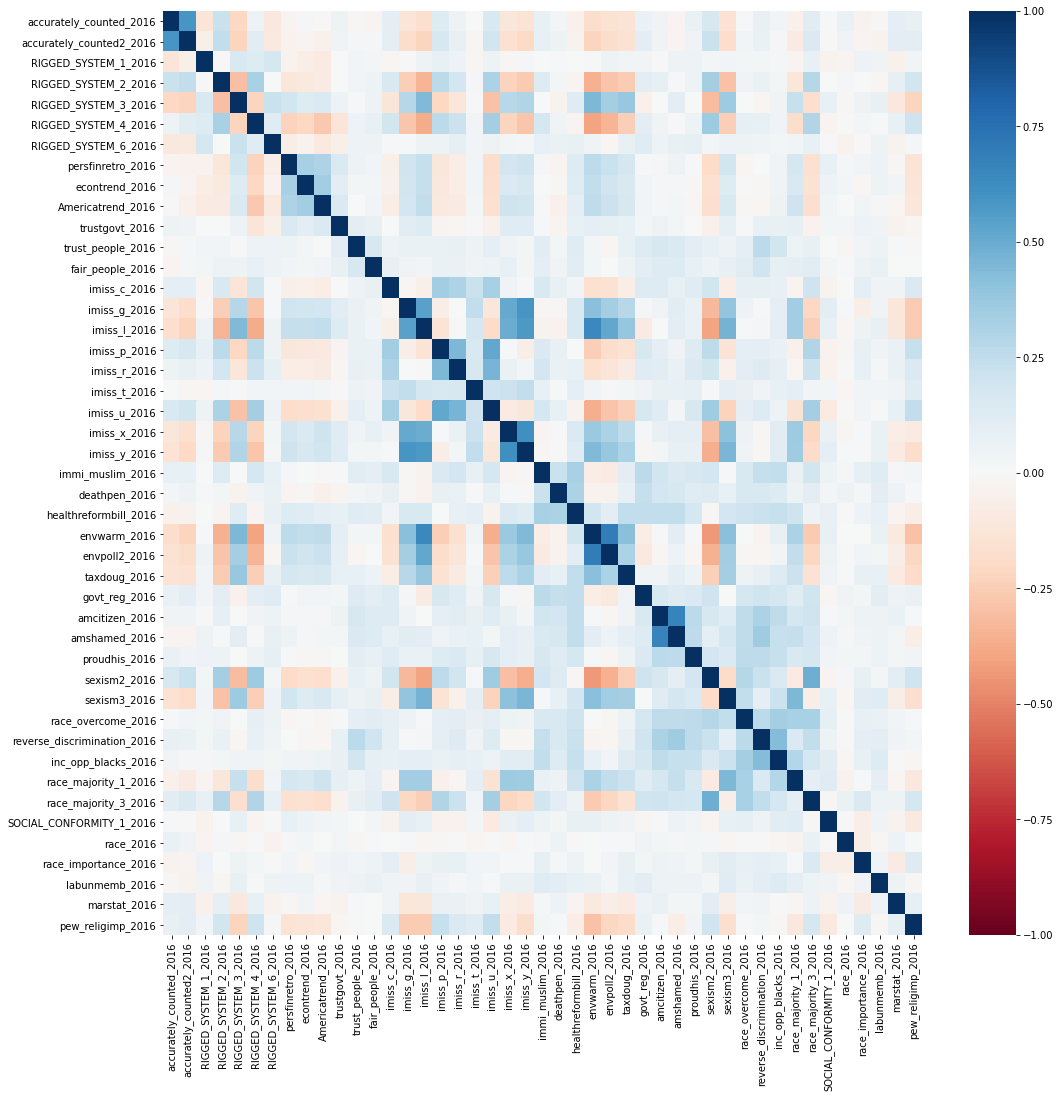

In [ ]:
# plot correlation matrix with heatmap
plt.figure(figsize=(17,17))
sns.heatmap(corr_df,vmin=-1,vmax=1,cmap='RdBu')
plt.show()

In [ ]:
# identify columns in the 2016 dataframe that were repeated in 2019 (same label except last character is 9 for 2019 instead of 6 for 2016)
repeated_topics_2016 = []
repeated_topics_2019 = []
for col in x.columns:
  col_2019 = col[:-1]+'9'
  if col_2019 in df_2019.columns:
    repeated_topics_2016.append(col)
    repeated_topics_2019.append(col_2019)

# add 2016 vote choice and anticipated 2020 vote choice to list of columns to collect
repeated_topics = ['presvote16post_2016','vote2020_2019'] + repeated_topics_2016 + repeated_topics_2019
#repeated_topics = repeated_topics.append('presvote16post_2016')
#print(repeated_topics)

# create a new small data frame that contains these columns (we can seperate them later, but this makes it easier to split into train and test sets)
df_sml = df[repeated_topics]
df_sml = df_sml[df_sml['presvote16post_2016'] <= 2] # only people who voted Clinton (1) or Trump (2) in 2016
df_sml['presvote16post_2016'] = df_sml['presvote16post_2016'].replace(2,0) # transform Trump values to 0 instead of 2 for use in logistic regression
df_sml = df_sml.dropna() # drop rows containing null values - should be small since the number of columns is limited
df_sml['vote2020_2019'] = df_sml['vote2020_2019'].replace([3,4,8],np.nan).replace(1,0).replace(2,1) # replace 2020 votes for neither Trump nor the Democrat with null, so they do not count in the vote averages used for comparison; transform Trump value from 1 to 0 and Democratic candidate value from 2 to 1 to mirror format for 2016 vote
#print(df_sml.head(50).to_string())

# split into 2016 attributes (x), 2019 attributes (x), and 2016 vote (y)
x_2016_sml = df_sml[repeated_topics_2016]
x_2019_sml = df_sml[repeated_topics_2019]
y_2016_sml = df_sml['presvote16post_2016']

# split into train and test sets, with random state set for repeatable results; model was run multiple times to optimize train size
X_train_sml, X_test_sml, y_train_sml, y_test_sml = train_test_split(x_2016_sml, y_2016_sml, random_state=50, train_size=0.45)
model_sml = LogisticRegression(max_iter=10000)
model_sml = model_sml.fit(X_train_sml, y_train_sml)

# percent of correct predictions using 2016 attributes to predict 2016 vote choice
print('Model accuracy against 2016 test data:\n',model_sml.score(X_test_sml, y_test_sml))

# percent of respondents who model predicts will vote for the Democratic candidate over Trump in 2020, using the same model that was built from 2016 data but applied to 2019 responses
pred_2020 = model_sml.predict(x_2019_sml)

print('\nModel prediction of proportion of voters who will choose the Democratic candidate in 2020:\n',pred_2019.mean(),'('+str(int(pred_2019.sum()))+' votes)')

# percent of respondents who actually said in 2019 that they would vote for the Democratic candidate in 2020 over Trump
print('\nActual proportion of respondents who would choose the Democratic candidate in 2020 over Donald Trump:\n',df_sml['vote2020_2019'].mean(),'('+str(int(df_sml['vote2020_2019'].sum()))+' votes)')

Model accuracy against 2016 test data:
 0.9045296167247386

Model prediction of proportion of voters who will choose the Democratic candidate in 2020:
 0.5369873514756611 (2802 votes)

Actual proportion of respondents who would choose the Democratic candidate in 2020 over Donald Trump:
 0.5254342431761787 (2541 votes)
